In [4]:
import pandas as pd
import json

# Read the CSV file
csv_file_path = r'D:\projects\MCRT\MCRT\data_processor\cif_pre_opr\simplified_symmetry\merged_crystals_symmetry.csv'
df = pd.read_csv(csv_file_path)

# Filter rows where only one column has a value of 1
filtered_df = df[(df == 1).sum(axis=1) == 1]

# Separate the DataFrame into different categories based on which column has the value 1
categories = {}
analysis = {}
columns = ["p1", "inversion_center", "mirror_plane", "rotation_axis", "screw_axis", "anti_axes", "glide_plane"]

for column in columns:
    crystals_list = filtered_df[filtered_df[column] == 1]['Crystal'].tolist()
    categories[column] = crystals_list
    analysis[column] = len(crystals_list)

# Combine the results and analysis into a single dictionary
result = {
    "analysis": analysis,
    "categories": categories,
}


# Save the result as a JSON file
output_file_path = r'D:\projects\MCRT\MCRT\data_processor\cif_pre_opr\simplified_symmetry\SEP_classified_crystals.json'
with open(output_file_path, 'w') as file:
    json.dump(result, file)

print("JSON file saved at:", output_file_path)


JSON file saved at: D:\projects\MCRT\MCRT\data_processor\cif_pre_opr\simplified_symmetry\SEP_classified_crystals.json


In [2]:
import json
# Recreate the previously generated JSON file for testing purpose
output_file_path = r'D:\Projects\MyProjects\MCRT\MCRT\data_processor\cif_pre_opr\simplified_symmetry\SEP_classified_crystals.json'
# Load the previously saved JSON file
with open(output_file_path, 'r') as file:
    data = json.load(file)

# Combine all names from categories into a single list
all_names = []
for category in data['categories'].values():
    all_names.extend(category)

# Create a new dictionary with the combined list under the key 'test'
new_data = {
    'test': all_names
}

# Save the new dictionary as a JSON file
output_file_path_combined = 'SEP_classification_crystals.json'
with open(output_file_path_combined, 'w') as file:
    json.dump(new_data, file)

tsne

In [66]:
from sklearn.manifold import TSNE
import pandas as pd
import ast

data = pd.read_parquet(r'D:\Projects\MyProjects\MCRT\MCRT\data_processor\cif_pre_opr\simplified_symmetry\ccdc_cls_feats2.parquet')
print("Parquet read complete")

# 提取特征
features = data.iloc[:, 1:]

print("start reduce.")

tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(features)

# 将结果转换为DataFrame
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])

# 将文件名和tsne结果合并
final_data = pd.concat([data['cif_id'], tsne_df], axis=1)

# 输出最终的DataFrame以检查
print(final_data)

# 保存到CSV
final_data.to_csv('tsne_results.csv', index=False)


Parquet read complete
start reduce.
          cif_id    tsne_1    tsne_2
0         SUYYIV -9.396236 -3.683021
1         UYUGED -1.383650 -9.441339
2         GASVUR -6.114196  0.037736
3         IHOZAH  7.172554  3.023731
4         LUMSER  7.676229  4.275775
...          ...       ...       ...
706092    KADCOI -8.590307  6.866595
706093    PHOXAC -2.628979  1.184463
706094    DAFDOE -1.215037 -4.462813
706095  KAHXAV01  3.414414 -0.650036
706096    BUNKAX  6.130671  2.582877

[706097 rows x 3 columns]


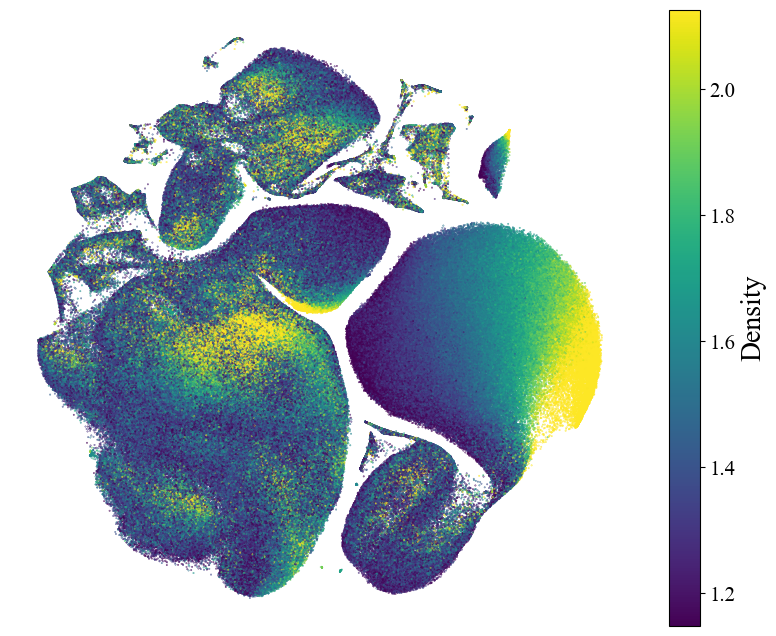

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
# Load tsne results
tsne_results = pd.read_csv('tsne_results.csv')

# Load density values
density_data = pd.read_csv('density.csv', header=None, names=['cif_id', 'Density'])

# Merge tsne results with density values on 'cif_id'
tsne_density = pd.merge(tsne_results, density_data, on='cif_id')

# Calculate the 5th and 95th percentiles
low_percentile = tsne_density['Density'].quantile(0.05)
high_percentile = tsne_density['Density'].quantile(0.95)

# Clip values at these percentiles
tsne_density['Clipped_Density'] = tsne_density['Density'].clip(lower=low_percentile, upper=high_percentile)

# Apply logarithmic transformation to clipped density
# tsne_density['Log_Density'] = np.log1p(tsne_density['Clipped_Density'])

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_density['tsne_1'], tsne_density['tsne_2'], c=tsne_density['Clipped_Density'], cmap='viridis', alpha=1,s=0.1)
cbar = plt.colorbar(scatter, label='Density')
cbar.ax.tick_params(labelsize=15)  # 调整颜色条刻度字体大小
cbar.set_label('Density', fontsize=20)  # 调整颜色条标签字体大小
plt.grid(False)
# 移除边框、坐标轴和网格线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().set_frame_on(False)
# Save the plot
plt.savefig('tsne_Log_Clip_Density_Visualization_3.png',  dpi=300, bbox_inches='tight')
plt.show()

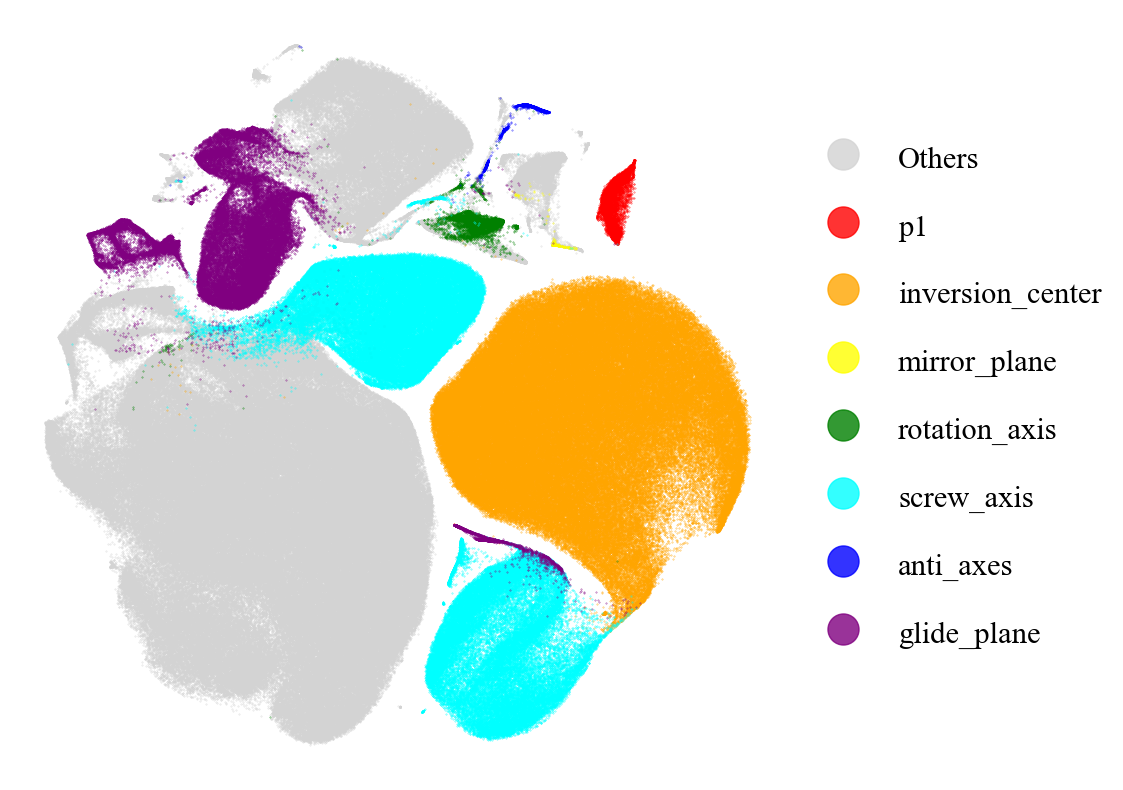

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import matplotlib.colors as mcolors
plt.rcParams["font.family"] = "Times New Roman"
# 从文件读取 JSON 数据
with open('SEP_classified_crystals.json', 'r') as file:
    json_data = json.load(file)

# 读取 CSV 文件
df = pd.read_csv('tsne_results.csv')

# 分配颜色
colors = ['#FF0000', '#FFA500', '#FFFF00', '#008000', '#00FFFF', '#0000FF', '#800080']  # 七原色
categories = list(json_data['categories'].keys())
category_color = {category: colors[i] for i, category in enumerate(categories)}

# 默认颜色为灰色
df['color'] = '#D3D3D3'
df['category_index'] = -1  # 用于存储类别索引，初始化为-1

# 分配特定颜色到特定类别中
for i, (category, items) in enumerate(json_data['categories'].items()):
    df.loc[df['cif_id'].isin(items), 'color'] = category_color[category]
    df.loc[df['cif_id'].isin(items), 'category_index'] = i

# 绘制散点图
plt.figure(figsize=(10, 10))
# 添加默认的灰色点
default_data = df[df['color'] == '#D3D3D3']
plt.scatter(default_data['tsne_1'], default_data['tsne_2'], color='#D3D3D3', alpha=0.8, label='Others', s=0.1)

# 绘制类别点
for i, (category, color) in enumerate(category_color.items()):
    category_data = df[df['category_index'] == i]
    plt.scatter(category_data['tsne_1'], category_data['tsne_2'], color=color, label=category, alpha=0.8, s=0.1)

# 调整图例中的点大小和字体
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=60, fontsize=22, frameon=False, handleheight=1.5, labelspacing=1.0)

# 放大图例中的点，并增加行间距
for handle in legend.legendHandles:
    handle._sizes = [500]

# 移除边框、坐标轴和网格线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().set_frame_on(False)
plt.grid(False)
plt.savefig('SEP_test_4.png',  dpi=300, bbox_inches='tight')
plt.show()


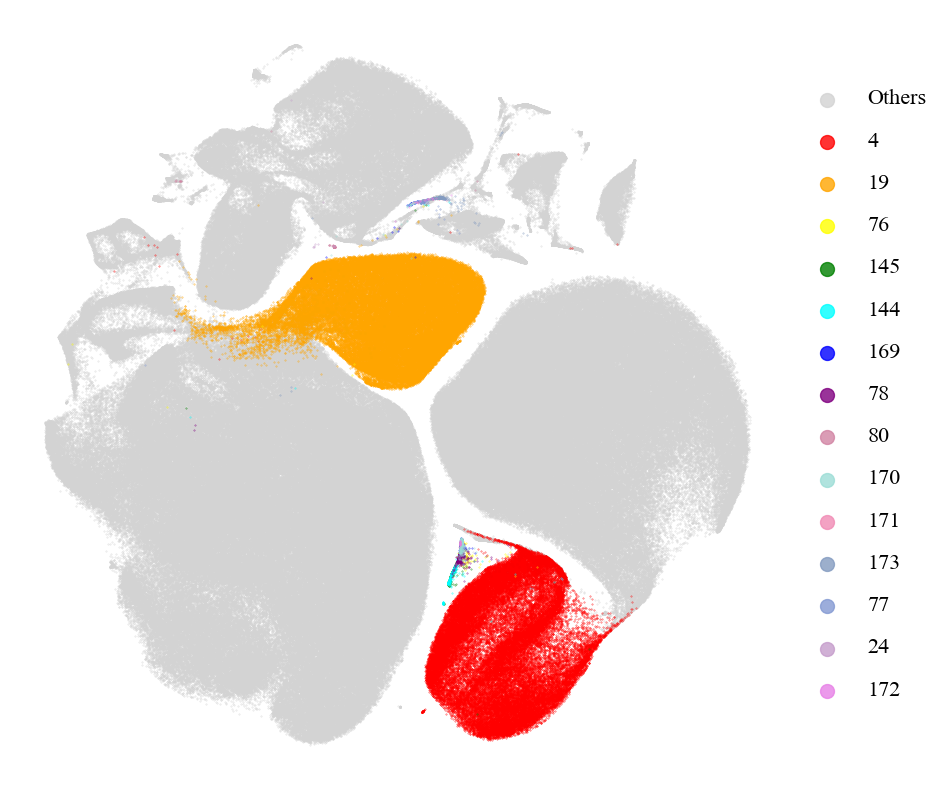

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import random
import matplotlib.colors as mcolors

plt.rcParams["font.family"] = "Times New Roman"

# 固定随机数种子
random.seed(42)

# 从文件读取 JSON 数据
with open('SEP_classified_crystals.json', 'r') as file:
    json_data = json.load(file)

# 读取 CSV 文件
df = pd.read_csv('tsne_results.csv')

# 读取 space_group.csv 文件（无表头）
space_group_df = pd.read_csv('D:/Projects/MyProjects/MCRT/MCRT/cifs/ccdc_mc/space_group.csv', header=None, names=['Crystal', 'SpaceGroup'])

# 从 JSON 文件中提取指定类别的晶体 ID
screw_axis_ids = json_data['categories']['screw_axis']

# 只保留在 screw_axis_ids 中的晶体
screw_axis_df = space_group_df[space_group_df['Crystal'].isin(screw_axis_ids)]

# 分配颜色
base_colors = ['#FF0000', '#FFA500', '#FFFF00', '#008000', '#00FFFF', '#0000FF', '#800080']  # 七原色
extra_colors_needed = len(screw_axis_df['SpaceGroup'].unique()) - len(base_colors)

# 如果需要更多颜色，则生成随机亮色
if extra_colors_needed > 0:
    extra_colors = [mcolors.to_hex([random.uniform(0.5, 1), random.uniform(0.5, 1), random.uniform(0.5, 1)]) for _ in range(extra_colors_needed)]
else:
    extra_colors = []

all_colors = base_colors + extra_colors
space_group_color = {group: all_colors[i % len(all_colors)] for i, group in enumerate(screw_axis_df['SpaceGroup'].unique())}

# 将所有晶体设置为灰色
df['color'] = '#D3D3D3'

# 确定需要着色的空间群类别
for group in screw_axis_df['SpaceGroup'].unique():
    matching_ids = screw_axis_df[screw_axis_df['SpaceGroup'] == group]['Crystal']
    df.loc[df['cif_id'].isin(matching_ids), 'color'] = space_group_color[group]

# 绘制散点图
plt.figure(figsize=(10, 10))

# 添加默认的灰色点
default_data = df[df['color'] == '#D3D3D3']
plt.scatter(default_data['tsne_1'], default_data['tsne_2'], color='#D3D3D3', alpha=0.8, label='Others', s=0.1)

# 绘制类别点
for group, color in space_group_color.items():
    category_data = df[df['color'] == color]
    plt.scatter(category_data['tsne_1'], category_data['tsne_2'], color=color, label=group, alpha=0.8, s=0.1)

# 调整图例中的点大小和字体
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=15, fontsize=16, frameon=False, handleheight=0.5, labelspacing=1.0)

# 放大图例中的点，并增加行间距
for handle in legend.legendHandles:
    handle._sizes = [100]

# 移除边框、坐标轴和网格线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().set_frame_on(False)
plt.grid(False)
plt.savefig('SEP_test_screw_axis_space_group.png', dpi=300, bbox_inches='tight')
plt.show()
